In [1]:
!pip install pystan==2.19.1.1
!pip install prophet

In [1]:
import os
import glob
import csv
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge

from darts.metrics import mae
from darts.metrics import mse
from darts.metrics import rmse

import random
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot
import datetime

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

In [2]:
def interpolate_method(df,column_name,methode,direction,order,limit):
  df[column_name] = df[column_name].interpolate(method=methode,limit_direction = direction,order=order,limit=limit)
  return df

def clean_csv(df,time_variable,quantitative_variable):
  df = df[[time_variable, quantitative_variable]].copy()
  df.columns = ['ds','y']
  df['y'] = (df['y'].apply(pd.to_numeric, errors='coerce')).to_frame()
  df = df.drop_duplicates(subset=['ds'])
  df['ds'] = pd.to_datetime(df.ds, errors = 'coerce')
  df = df.dropna(subset=['ds'])
  df = df.sort_values(by=['ds'])
  pourcentage = ((len(df) - df['y'].count()) / len(df)) * 100
  if (pourcentage <= 2):
    df = df.dropna(subset=['y'])
  elif((pourcentage > 2) and (pourcentage < 25)):
    df = interpolate_method(df,'y',"polynomial",None,2,None)
  elif((pourcentage >= 25)):
    print("La base de donnée comporte un grand nombre de données manquantes pour être étudiée.")
  if(len(df) > 1000):
      supr = len(df) - 1000
      df = df[:-supr]
  return df, pourcentage

In [3]:
def naive_method(df):
  if len(df.columns) > 2:
    print("Erreur : il y a plus d'une seule variable")
  elif(len(df) < 500):
      print("Erreur : le data frame est trop petit")
  else:
    n = len(df)
    period = 300
    train_len = n-period
    train = df[0:train_len]
    val = df[train_len:]
    
    series = TimeSeries.from_dataframe(df, 'ds', 'y')
    train_scaled = TimeSeries.from_dataframe(train, 'ds', 'y')
    val_scaled = TimeSeries.from_dataframe(val, 'ds', 'y')
    
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train_scaled)
    val_scaled = scaler.transform(val_scaled)
    series_scaled = scaler.transform(series)
        
    y_hat_naive = val.copy()
    y_hat_naive['naive_forecast'] = train['y'][train_len-1]
    
    y_hat_naive_scaled = TimeSeries.from_dataframe(y_hat_naive, 'ds', 'naive_forecast')
    y_hat_naive_scaled = scaler.transform(y_hat_naive_scaled)
    
    MAE = mae(val_scaled,y_hat_naive_scaled)
    MSE = mse(val_scaled,y_hat_naive_scaled)
    RMSE = rmse(val_scaled,y_hat_naive_scaled)


    return(train_scaled, val_scaled, y_hat_naive_scaled, MAE, MSE, RMSE)

In [4]:
def prophet_model(df,frequency):
  if len(df.columns) > 2:
    print("Erreur : il y a plus d'une seule variable")
  elif(len(df) < 500):
    print("Erreur : le data frame est trop petit")
  else:
    n = len(df)
    period = 300
    df_fit = df[:-period]
    df_true = df[n-period:]
    
    series = TimeSeries.from_dataframe(df, 'ds', 'y')
    train = TimeSeries.from_dataframe(df_fit, 'ds', 'y')
    val = TimeSeries.from_dataframe(df_true, 'ds', 'y')
    
    scaler = Scaler()
    train_scaled = scaler.fit_transform(train)
    val_scaled = scaler.transform(val)
    series_scaled = scaler.transform(series)
    
    m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality = True)
    m.fit(df_fit)
    future = m.make_future_dataframe(periods=period*2, freq=frequency)
    if (frequency == 'M'):
        for i in range (n-period, len(future)):
            future['ds'][i] = future['ds'][i] + datetime.timedelta(days=1)
    forecast = m.predict(future)
    df_true_prediction = pd.merge(df_true, forecast, how ='inner', on =['ds'])
    df_true_prediction = df_true_prediction[['ds', 'y', 'yhat', 'yhat_upper', 'yhat_lower']].copy()
    
    pred = TimeSeries.from_dataframe(df_true_prediction, 'ds', 'yhat')
    pred_scaled = scaler.transform(pred)
    
    MAE = mae(val_scaled,pred_scaled)
    MSE = mse(val_scaled,pred_scaled)
    RMSE = rmse(val_scaled, pred_scaled)
    
    return(train_scaled, val_scaled, pred_scaled, MAE, MSE, RMSE)

In [5]:
os.getcwd()

'/home/nazim/MAIN4/Transformers/Code/700-300'

In [6]:
os.chdir('../../Datasets/Energies')
os.getcwd()

'/home/nazim/MAIN4/Transformers/Datasets/Energies'

In [7]:
!ls

D_-_spain_biomass.csv	       D-spain_other.csv
D_-_spain_fossilbrowncoal.csv  D-spain_other_ren.csv
D_-_spain_fossilgas.csv        D-spain_reservoir.csv
D_-_spain_fossilhardcoal.csv   D-spain_river.csv
D_-_spain_fossiloil.csv        D-spain_solar.csv
D-spain_hydroconsump.csv       D-spain_waste.csv
D-spain_nuclear.csv	       D-spain_wind_onshore.csv


In [8]:
def predict():
    file_name = []
    df = []
    pourcentage = []

    df_fit_naive = []
    df_true_prediction_naive = []
    forecast_naive = []

    df_fit_prophet = []
    df_true_prediction_prophet = []
    forecast_prophet = []

    results_naive = pd.DataFrame(columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
    results_prophet = pd.DataFrame(columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])

    i = 0
    for files in glob.glob("*.csv"):
        file_name.append(Path(files).stem)
        print(file_name[i])
        df_not_cleaned = pd.read_csv(files)
        df_clean, pourcentage_actual = clean_csv(df_not_cleaned, "Date","Value")
        df.append(df_clean)
        pourcentage.append(pourcentage_actual)

        df_fit_temp_naive , df_true_prediction_temp_naive , forecast_temp_naive , MAE_naive, MSE_naive, RMSE_naive = naive_method(df[i])
        df_fit_naive.append(df_fit_temp_naive)
        df_true_prediction_naive.append(df_true_prediction_temp_naive)
        forecast_naive.append(forecast_temp_naive)

        df_fit_temp_prophet , df_true_prediction_temp_prophet , forecast_temp_prophet , MAE_prophet, MSE_prophet, RMSE_prophet = prophet_model(df[i],file_name[i][0])
        df_fit_prophet.append(df_fit_temp_prophet)
        df_true_prediction_prophet.append(df_true_prediction_temp_prophet)
        forecast_prophet.append(forecast_temp_prophet)

        df_new_row_naive = pd.DataFrame(data=np.array([[file_name[i],'Naive Method',MAE_naive,MSE_naive,RMSE_naive]]), columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
        df_new_row_prophet = pd.DataFrame(data=np.array([[file_name[i],'Prophet Method',MAE_prophet,MSE_prophet,RMSE_prophet]]), columns=['DATA_SET_NAME','Method','MAE','MSE','RMSE'])
        results_naive = pd.concat([results_naive,df_new_row_naive], ignore_index=True)
        results_prophet = pd.concat([results_prophet,df_new_row_prophet], ignore_index=True)
        i = i +1

    return file_name,df, pourcentage, df_fit_naive, df_true_prediction_naive, forecast_naive, results_naive, df_fit_prophet, df_true_prediction_prophet, forecast_prophet, results_prophet

In [9]:
file_name, df, pourcentage, df_fit_naive, df_true_prediction_naive, forecast_naive, results_naive, df_fit_prophet, df_true_prediction_prophet, forecast_prophet, results_prophet = predict()

D-spain_reservoir
Initial log joint probability = -24.3715
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       886.428    0.00089095       69.4387   1.367e-05       0.001      139  LS failed, Hessian reset 
      99       886.468   1.02832e-05       70.1818      0.8856      0.8856      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       886.469   1.08487e-05        54.809   1.811e-07       0.001      204  LS failed, Hessian reset 
     135        886.47   7.68149e-07       64.0116   1.182e-08       0.001      293  LS failed, Hessian reset 
     145        886.47   2.45629e-08         52.39      0.5165      0.5165      307   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
D_-_spain_fossilhardcoal
Initial log joint probability = -37.8905
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

D_-_spain_biomass
Initial log joint probability = -9.79196
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1344.98    0.00148624        63.984      0.6937      0.6937      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1345.52   0.000164203        87.031           1           1      267   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       1345.62    0.00122807       122.079   1.391e-05       0.001      328  LS failed, Hessian reset 
     299       1345.71   5.80392e-07       75.7869      0.6545      0.6545      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1346.36     0.0129309       90.0314           1           1      566   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     403       1346.41

In [10]:
df

[            ds        y
 0   2015-01-01  52005.0
 1   2015-01-02  89159.0
 2   2015-01-03  95266.0
 3   2015-01-04  77792.0
 4   2015-01-05  43206.0
 ..         ...      ...
 995 2017-09-22  33498.0
 996 2017-09-23  31385.0
 997 2017-09-24  25068.0
 998 2017-09-25  28449.0
 999 2017-09-26  30484.0
 
 [1000 rows x 2 columns],
             ds         y
 0   2015-01-01  101917.0
 1   2015-01-02   29688.0
 2   2015-01-03   32262.0
 3   2015-01-04   53879.0
 4   2015-01-05   44880.0
 ..         ...       ...
 995 2017-09-22   97151.0
 996 2017-09-23   82386.0
 997 2017-09-24   83816.0
 998 2017-09-25  106490.0
 999 2017-09-26  122429.0
 
 [1000 rows x 2 columns],
             ds        y
 0   2015-01-01   6178.0
 1   2015-01-02      0.0
 2   2015-01-03      0.0
 3   2015-01-04      0.0
 4   2015-01-05    430.0
 ..         ...      ...
 995 2017-09-22  19553.0
 996 2017-09-23  15968.0
 997 2017-09-24  16457.0
 998 2017-09-25  20820.0
 999 2017-09-26  21409.0
 
 [1000 rows x 2 columns],
    

In [11]:
results_naive

,DATA_SET_NAME,Method,MAE,MSE,RMSE
0,D-spain_reservoir,Naive Method,0.1037722031655086,0.02072921407325186,0.1439764358263249
1,D_-_spain_fossilhardcoal,Naive Method,0.32286220715750835,0.1531302419479776,0.3913185939205772
2,D_-_spain_fossilbrowncoal,Naive Method,0.36938753762186605,0.2182660354583561,0.46718950700797646
3,D-spain_river,Naive Method,0.16963161171038085,0.039405639849730396,0.19850853848066685
4,D_-_spain_fossilgas,Naive Method,0.1914385985162344,0.04859658827342552,0.22044633876167125
5,D-spain_wind_onshore,Naive Method,0.27686277796566144,0.09426714192338105,0.3070295456847452
6,D-spain_solar,Naive Method,0.4236103640680435,0.2459686964079206,0.4959523126349151
7,D-spain_other,Naive Method,0.12167150693772186,0.04732901847924588,0.21755233503514937
8,D-spain_hydroconsump,Naive Method,0.14085106731541094,0.029373369078536875,0.17138660705707687
9,D-spain_other_ren,Naive Method,0.2745567375886525,0.09315238167094213,0.3052087509737264


In [12]:
results_prophet

,DATA_SET_NAME,Method,MAE,MSE,RMSE
0,D-spain_reservoir,Prophet Method,0.25004053420486116,0.0830099126222292,0.28811440891116363
1,D_-_spain_fossilhardcoal,Prophet Method,0.3615582282982228,0.1796567057857961,0.42385929951553036
2,D_-_spain_fossilbrowncoal,Prophet Method,0.44150415949998156,0.2584321780089523,0.5083622507709953
3,D-spain_river,Prophet Method,0.27299149797813993,0.09606061326317339,0.3099364664946243
4,D_-_spain_fossilgas,Prophet Method,0.15437763940183072,0.04303617827483324,0.2074516287591718
5,D-spain_wind_onshore,Prophet Method,0.18026579119632327,0.04561419107515198,0.21357479035492924
6,D-spain_solar,Prophet Method,0.1993762897000968,0.05772503286381227,0.24026034392677512
7,D-spain_other,Prophet Method,0.23970232277299716,0.07208701141812543,0.26849024454926745
8,D-spain_hydroconsump,Prophet Method,0.16041861493806805,0.036321982216150024,0.19058326845804177
9,D-spain_other_ren,Prophet Method,0.12830178062491537,0.023207059317862547,0.15233863370091827


In [13]:
results_prophet.to_csv(r'../../Resultats/Resultats_300/prophet_results_energies.csv', index = False)
results_naive.to_csv(r'../../Resultats/Resultats_300/naive_results_energies.csv', index = False)

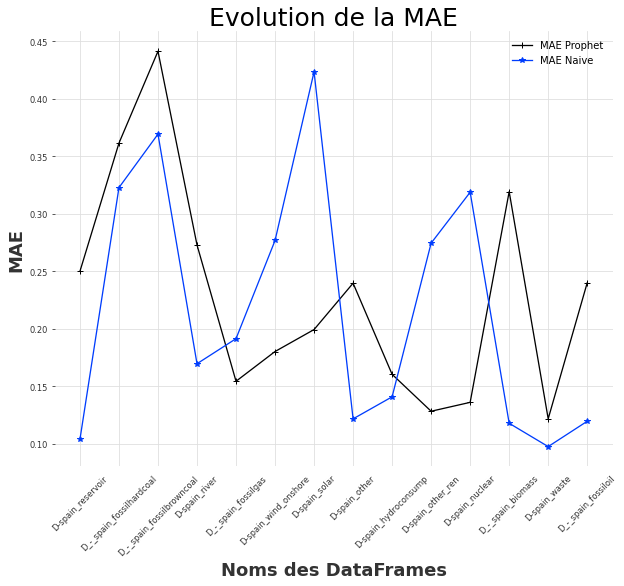

In [14]:
figure(figsize=(10, 8))
plt.axes()

liste_MAE1_prophet = results_prophet["MAE"].tolist()
liste_MAE_prophet = [float(item) for item in liste_MAE1_prophet]

liste_MAE1_naive = results_naive["MAE"].tolist()
liste_MAE_naive = [float(item) for item in liste_MAE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
y = np.array(liste_MAE_prophet)
y2 = np.array(liste_MAE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'MAE Prophet', marker="+")
plt.plot(x, y2, label = 'MAE Naive', marker="*")
plt.title("Evolution de la MAE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("MAE",fontsize=18)
plt.legend()
plt.show()

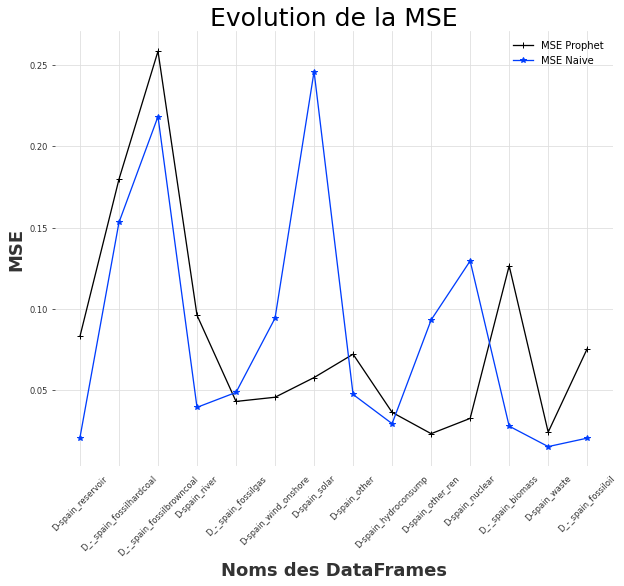

In [15]:
figure(figsize=(10, 8))
plt.axes()

liste_MSE1_prophet = results_prophet["MSE"].tolist()
liste_MSE_prophet = [float(item) for item in liste_MSE1_prophet]

liste_MSE1_naive = results_naive["MSE"].tolist()
liste_MSE_naive = [float(item) for item in liste_MSE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
y = np.array(liste_MSE_prophet)
y2 = np.array(liste_MSE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'MSE Prophet', marker="+")
plt.plot(x, y2, label = 'MSE Naive', marker="*")
plt.title("Evolution de la MSE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("MSE",fontsize=18)
plt.legend()
plt.show()

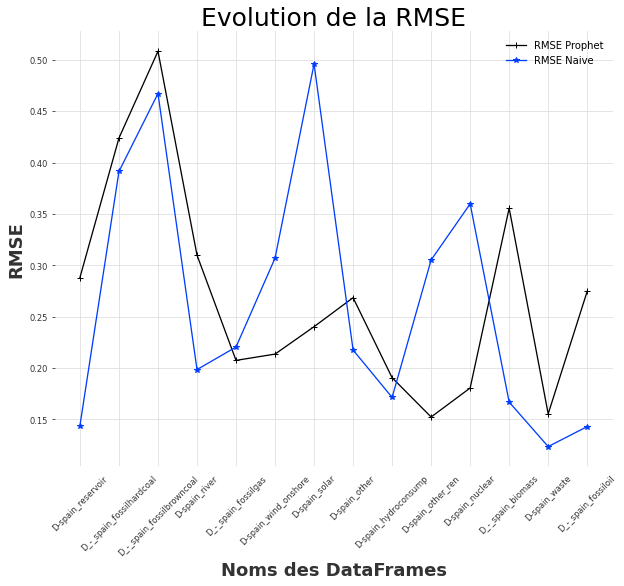

In [16]:
figure(figsize=(10, 8))
plt.axes()

liste_RMSE1_prophet = results_prophet["RMSE"].tolist()
liste_RMSE_prophet = [float(item) for item in liste_RMSE1_prophet]

liste_RMSE1_naive = results_naive["RMSE"].tolist()
liste_RMSE_naive = [float(item) for item in liste_RMSE1_naive]

x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
y = np.array(liste_RMSE_prophet)
y2 = np.array(liste_RMSE_naive)

liste_NAME = results_prophet["DATA_SET_NAME"].tolist()
my_xticks = liste_NAME
plt.xticks(x, my_xticks)
plt.xticks(rotation=45)
plt.plot(x, y, label = 'RMSE Prophet', marker="+")
plt.plot(x, y2, label = 'RMSE Naive', marker="*")
plt.title("Evolution de la RMSE",fontsize=25)
plt.xlabel("Noms des DataFrames",fontsize=18)
plt.ylabel("RMSE",fontsize=18)
plt.legend()
plt.show()

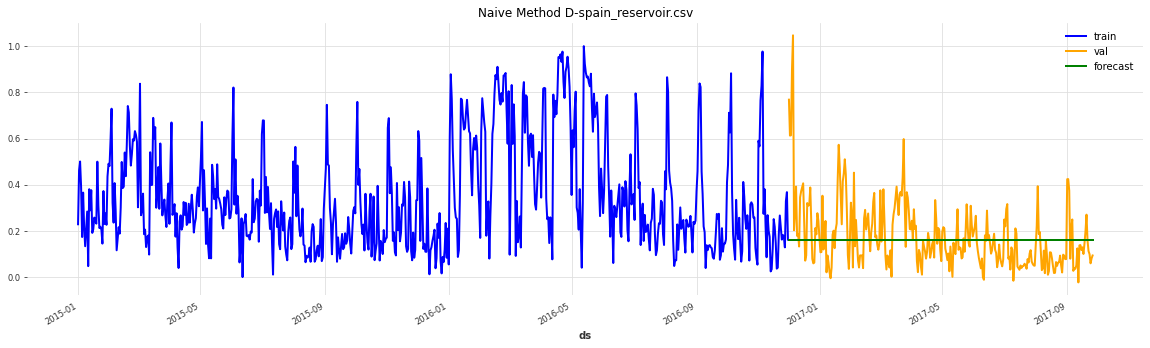

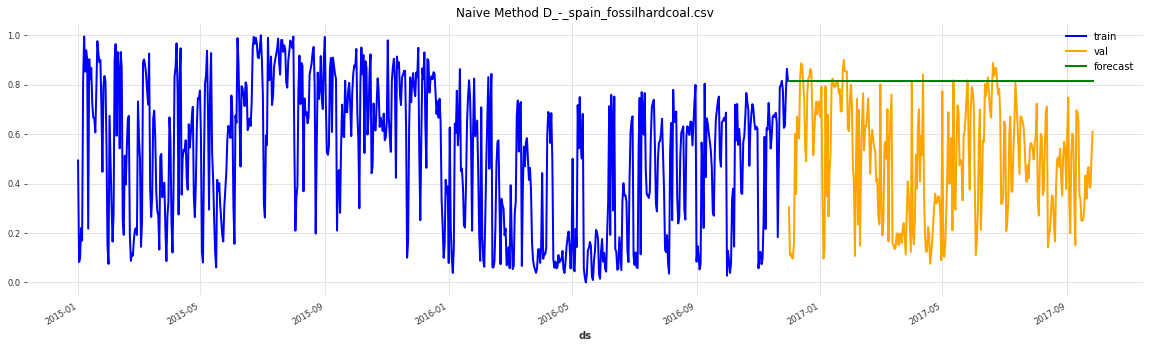

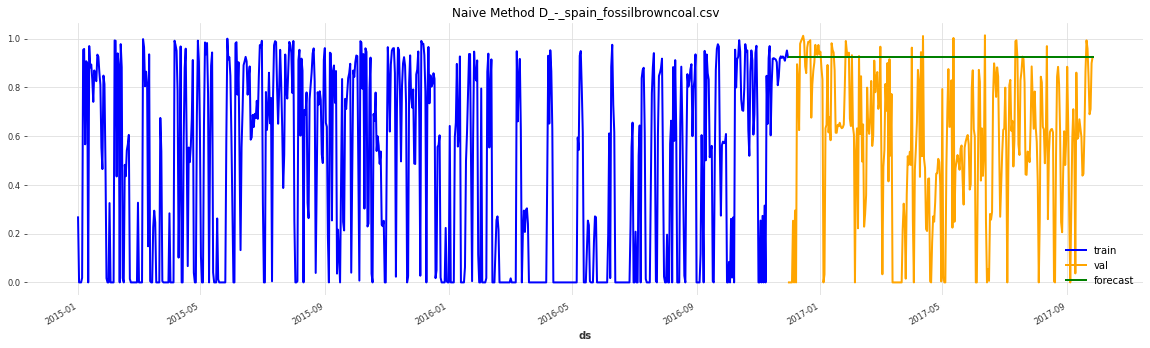

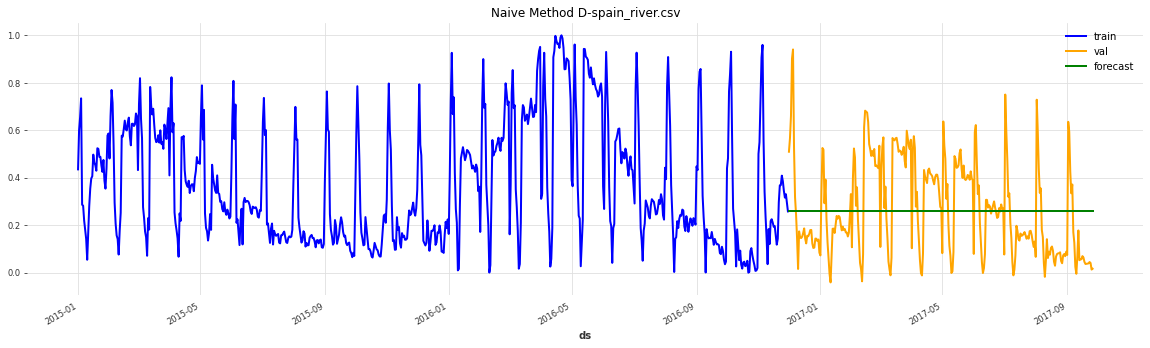

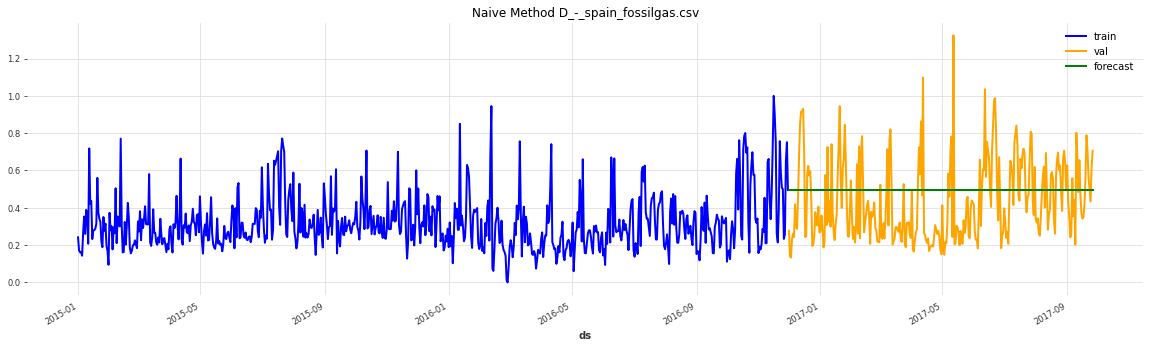

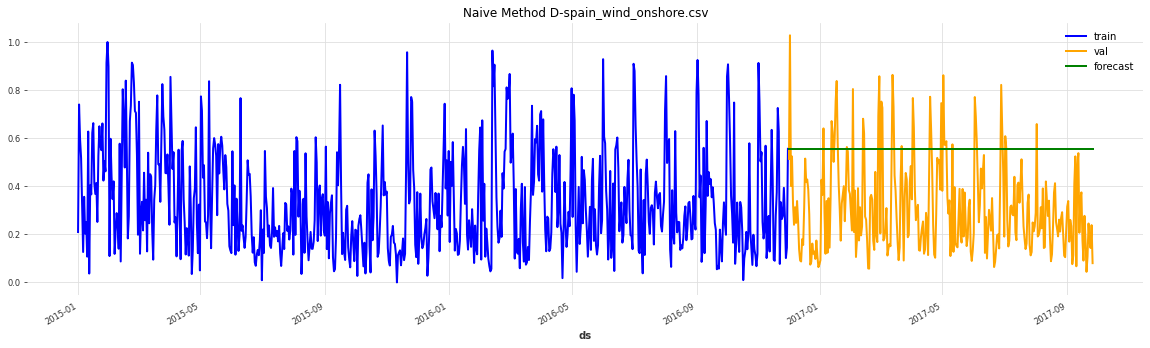

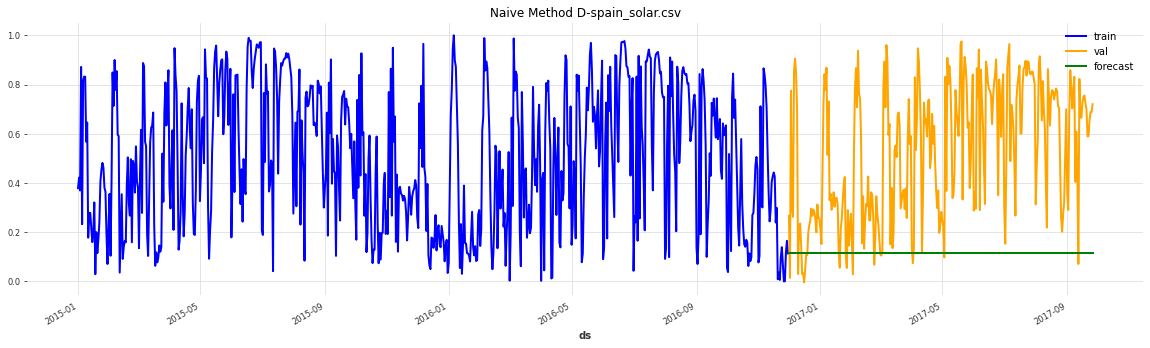

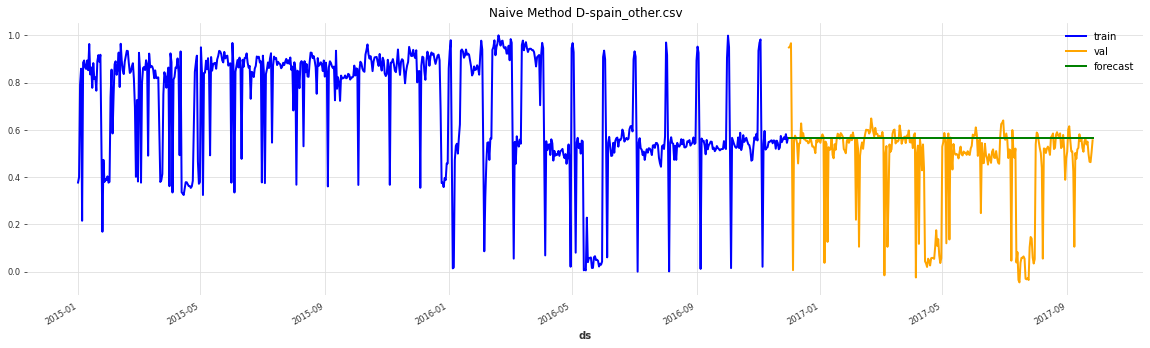

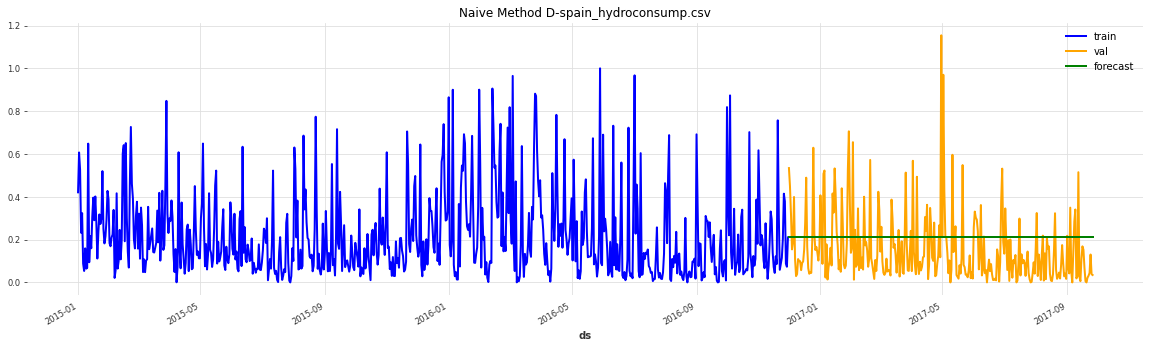

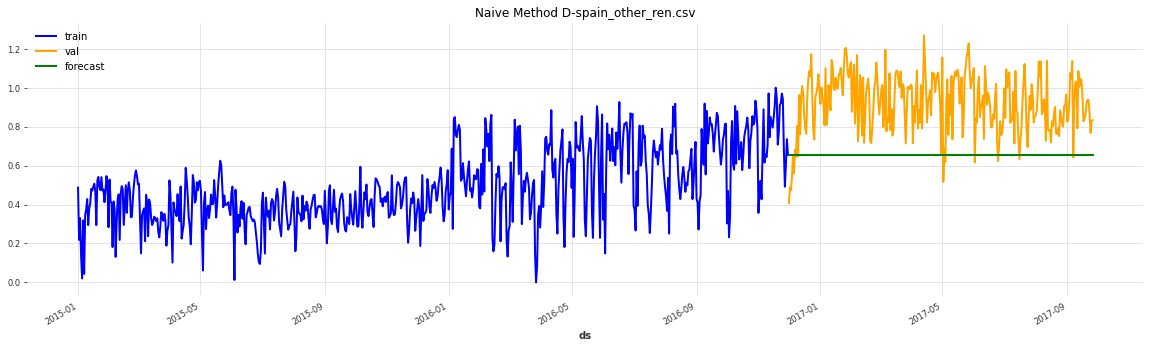

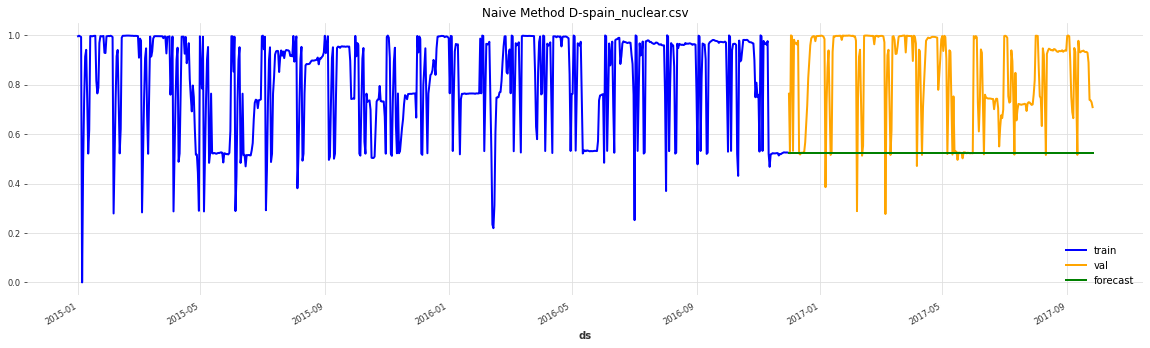

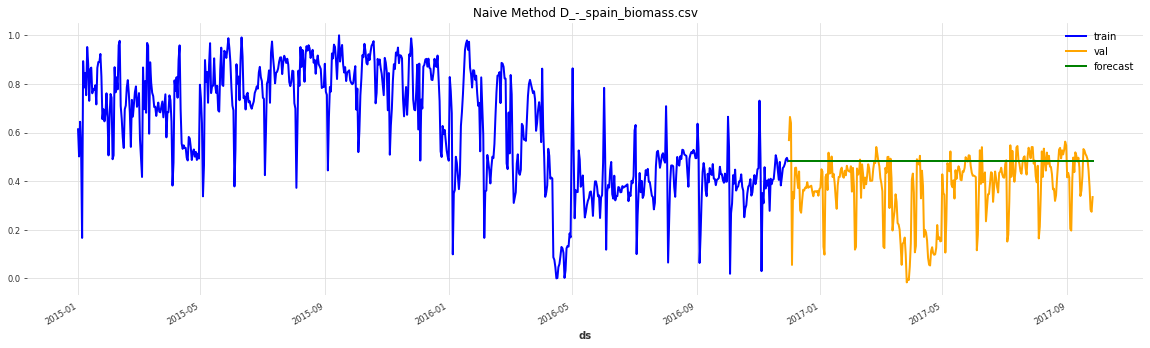

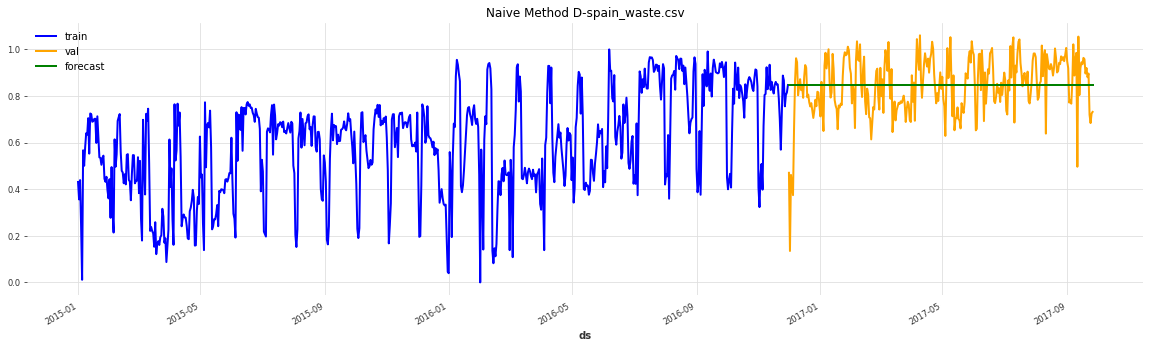

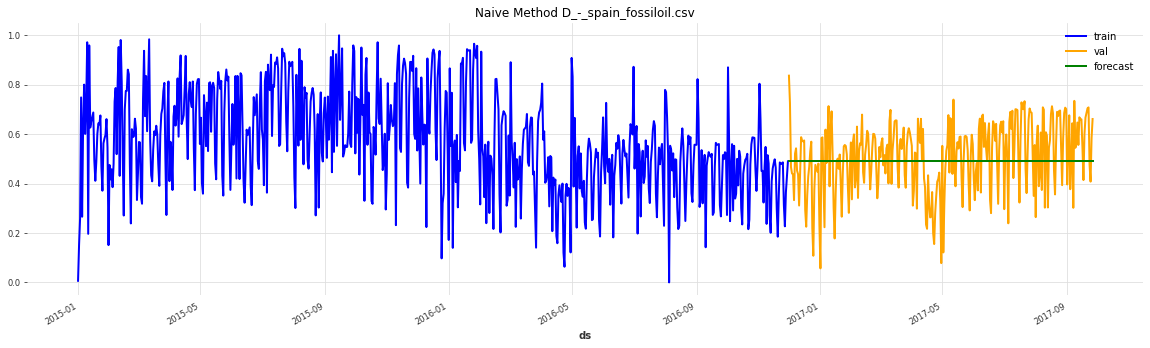

In [17]:
for i in range(len(df_fit_naive)):
    plt.figure(figsize=(20,5))
    df_fit_naive[i].plot(color ='blue', label="train")
    df_true_prediction_naive[i].plot(color ='orange', label="val")
    forecast_naive[i].plot(color ='green',label="forecast")
    plt.title('Naive Method '+file_name[i]+".csv")    
    plt.legend(loc='best')
    plt.show()

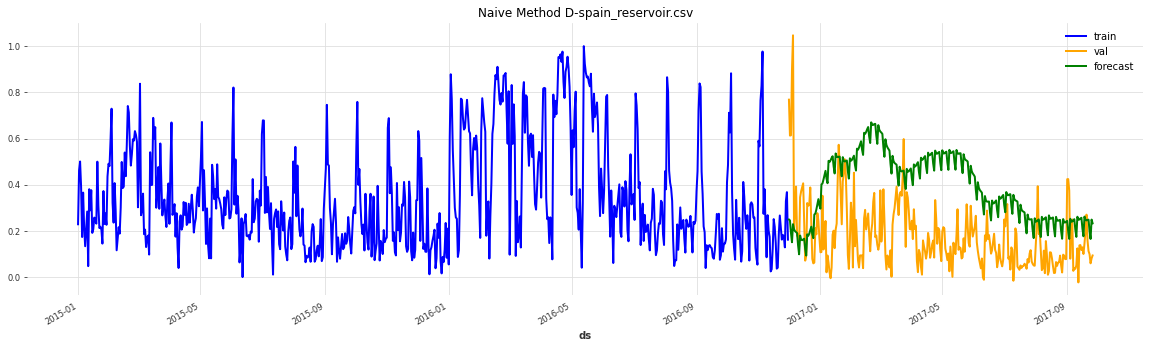

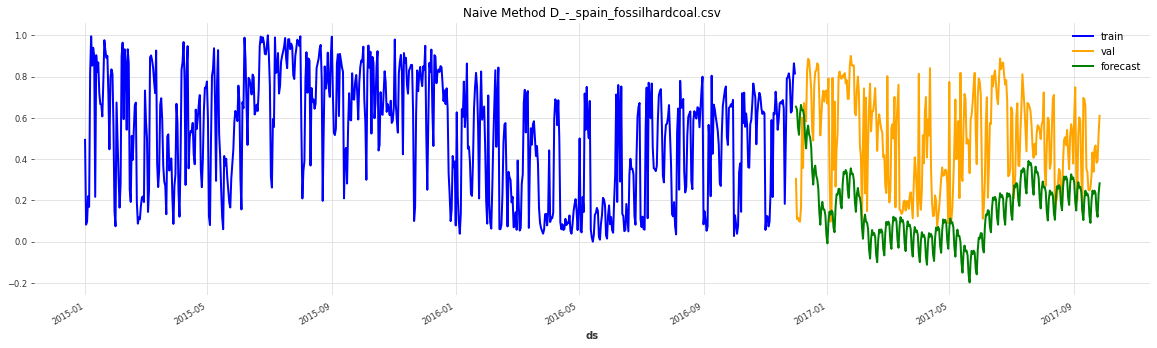

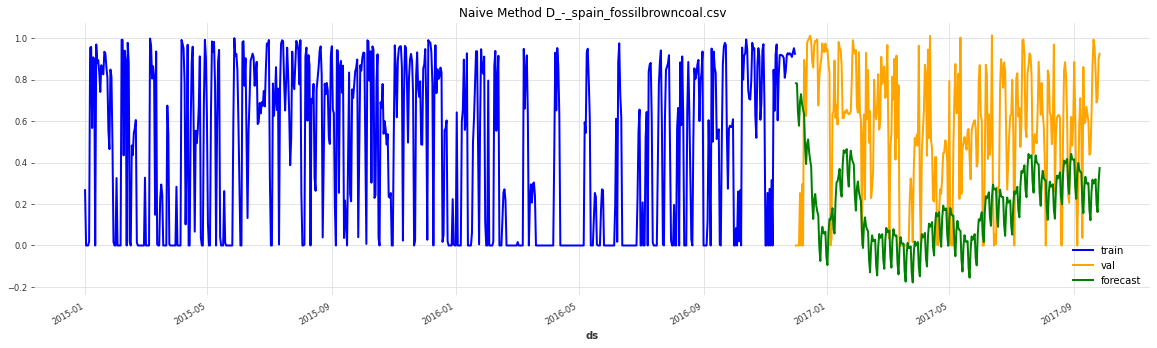

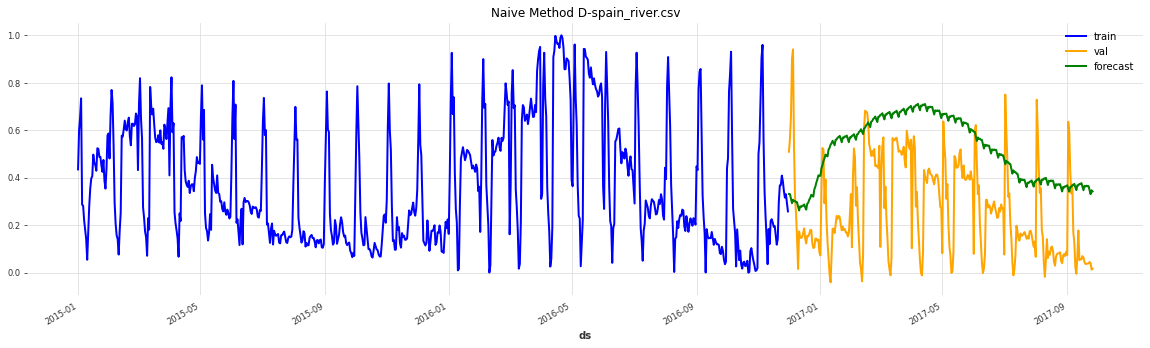

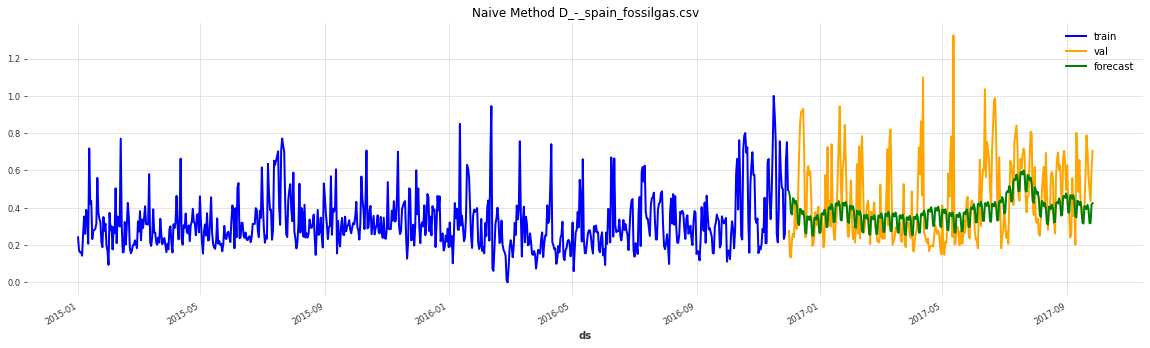

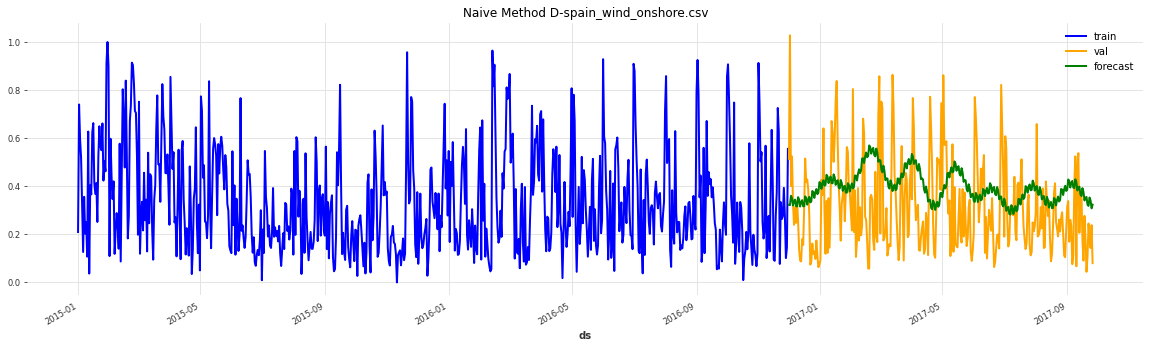

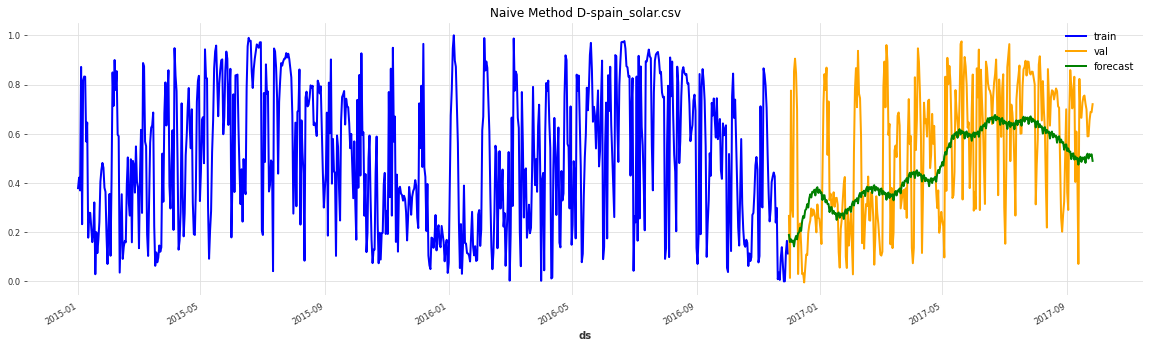

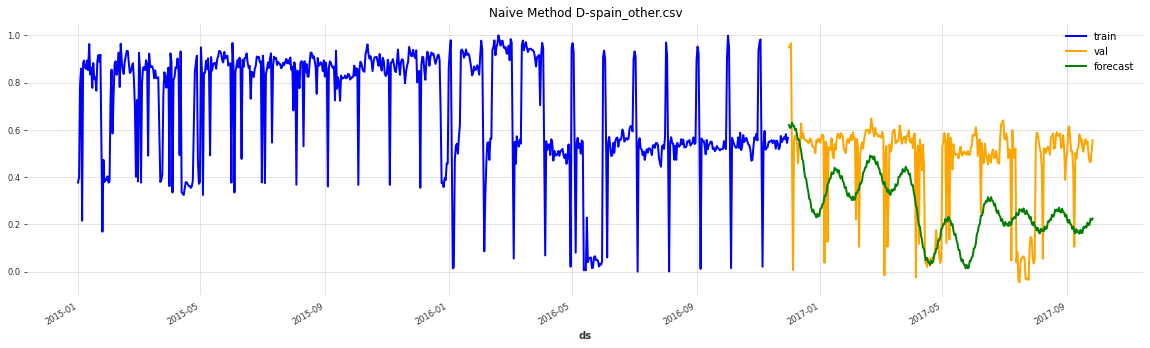

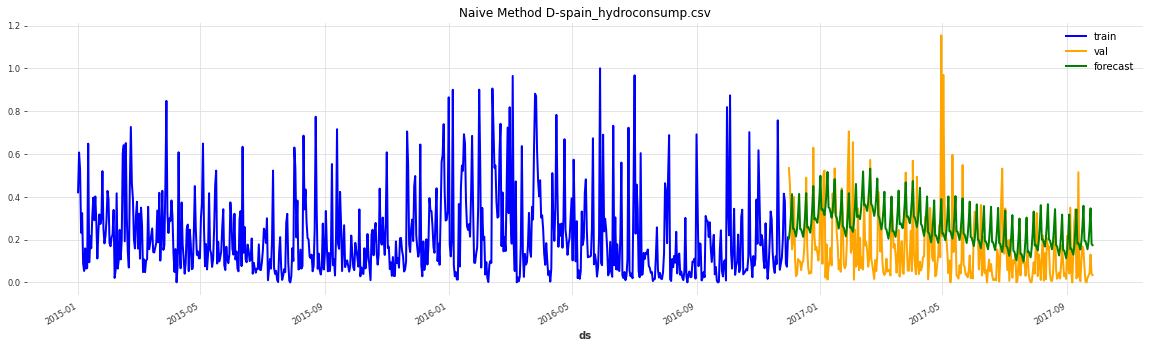

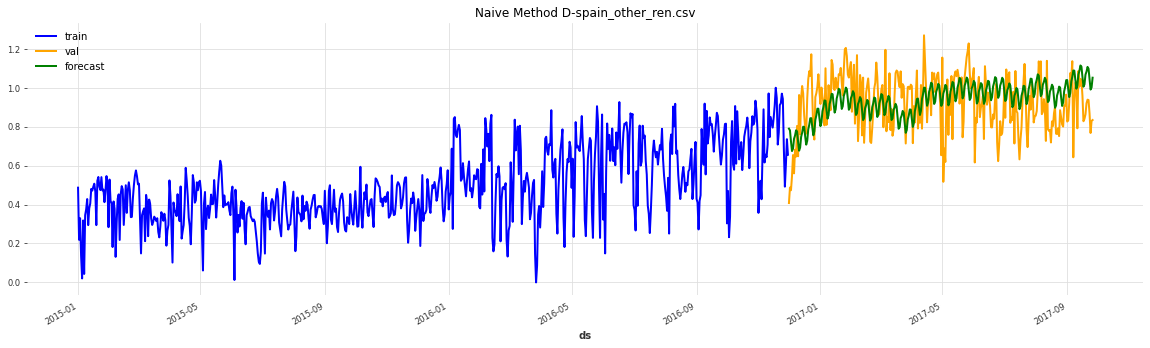

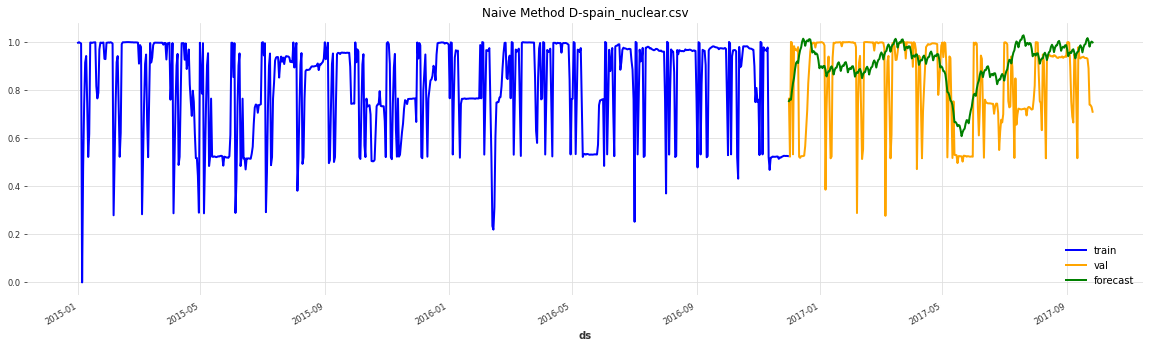

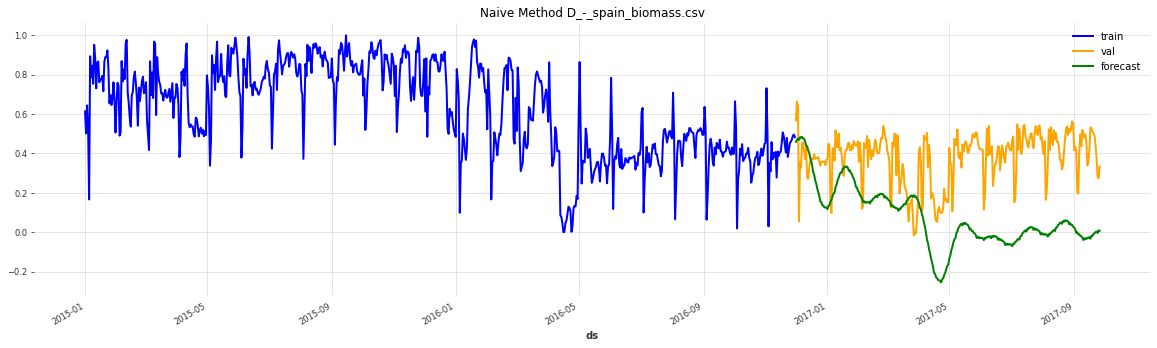

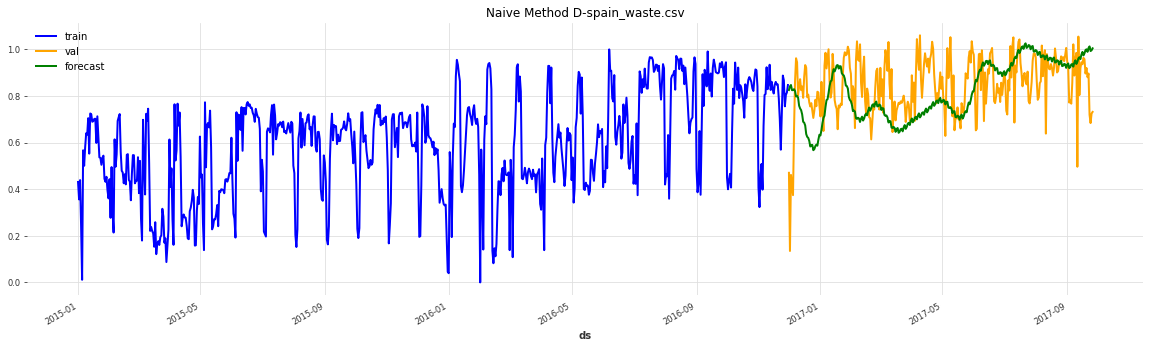

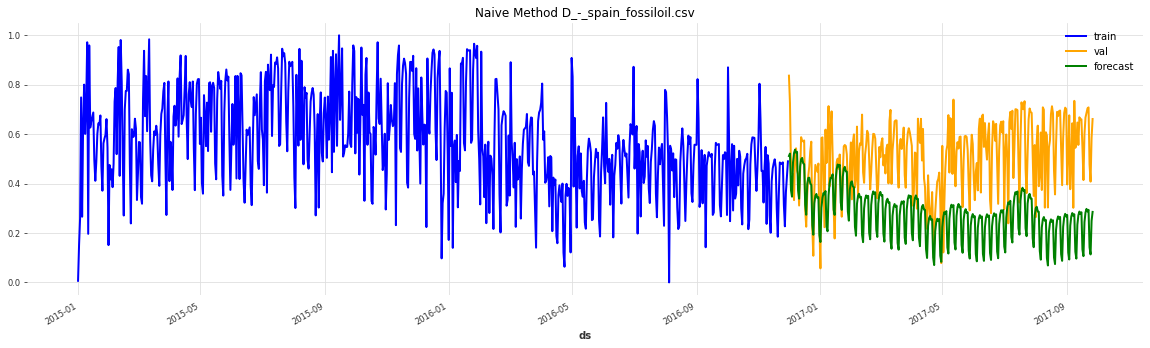

In [18]:
for i in range(len(df_fit_prophet)):
    plt.figure(figsize=(20,5))
    df_fit_prophet[i].plot(color ='blue', label="train")
    df_true_prediction_prophet[i].plot(color ='orange', label="val")
    forecast_prophet[i].plot(color ='green',label="forecast")
    plt.title('Naive Method '+file_name[i]+".csv")    
    plt.legend(loc='best')
    plt.show()

In [19]:
for i in range(len(df_fit_naive)):
    if len(df_fit_naive[i]) != 700 :
        print("ERROR, len(df_fit_naive[{}] = ".format(i, len(df_fit_naive[i])))
    elif len(df_true_prediction_naive[i]) != 300 :
        print("ERROR, len(df_true_prediction_naive[{}] = ".format(i, len(df_true_prediction_naive[i])))
    else:
        print("Tout est bon pour data i = ", i)
    print("-----")

Tout est bon pour data i =  0
-----
Tout est bon pour data i =  1
-----
Tout est bon pour data i =  2
-----
Tout est bon pour data i =  3
-----
Tout est bon pour data i =  4
-----
Tout est bon pour data i =  5
-----
Tout est bon pour data i =  6
-----
Tout est bon pour data i =  7
-----
Tout est bon pour data i =  8
-----
Tout est bon pour data i =  9
-----
Tout est bon pour data i =  10
-----
Tout est bon pour data i =  11
-----
Tout est bon pour data i =  12
-----
Tout est bon pour data i =  13
-----


In [20]:
for i in range(len(df_fit_prophet)):
    if len(df_fit_prophet[i]) != 700 :
        print("ERROR, len(df_fit_prophet[{}] = ".format(i, len(df_fit_prophet[i])))
    elif len(df_true_prediction_prophet[i]) != 300 :
        print("ERROR, len(df_true_prediction_prophet[{}] = ".format(i, len(df_true_prediction_prophet[i])))
    else:
        print("Tout est bon pour data i = ", i)
    print("-----")

Tout est bon pour data i =  0
-----
Tout est bon pour data i =  1
-----
Tout est bon pour data i =  2
-----
Tout est bon pour data i =  3
-----
Tout est bon pour data i =  4
-----
Tout est bon pour data i =  5
-----
Tout est bon pour data i =  6
-----
Tout est bon pour data i =  7
-----
Tout est bon pour data i =  8
-----
Tout est bon pour data i =  9
-----
Tout est bon pour data i =  10
-----
Tout est bon pour data i =  11
-----
Tout est bon pour data i =  12
-----
Tout est bon pour data i =  13
-----
